**Author**: JW Debelius<br>
**Date**: Winter 2023 <br>
**Enviroment**: `micc-2021.11`

In this notebook, we'll handled processing the replication set. We're using data from Cronin et al, 2022 ([doi: 10.1093/narcan/zcac011](https://academic.oup.com/narcancer/article/4/2/zcac011/6565303)) avaliable through ENA ([PRJEB47197](https://www.ebi.ac.uk/ena/browser/view/PRJEB47197)). And the data was downloaded from ENA (); we used the "download all files" functionality and moved the download into `data/flemer/ena_files`. The sample description came from ENA.
Additionally, metadata was by Dr. Peter Cronin, also avalible as supplementary file 1 from the publications, which we placed in the `data/flemer` directory.

Additionally, this notebook needs to be run *at the end* of the series to insure the correct tables are avalaible for validation.

In [1]:
import os
import re

import numpy as np
import pandas as pd
import scipy

import skbio

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sn

import patsy
import statsmodels.api as sms

from qiime2 import Metadata, Artifact

import qiime2.plugins.demux.actions as q2_demux
import qiime2.plugins.cutadapt.actions as q2_cutadapt
import qiime2.plugins.dada2.actions as q2_dada2
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.feature_classifier.actions as q2_feature_classifier
import qiime2.plugins.feature_table.actions as q2_feature_table
import qiime2.plugins.gemelli.actions as q2_gemelli
import qiime2.plugins.vsearch.actions as q2_vsearch

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']


In [2]:
%matplotlib inline

In [3]:
np.random.seed(65)

# Load ENA information

We started by downloading the file report from ENA, and moving it the "data folder", along with the reads from ENA ([PRJEB47197](https://www.ebi.ac.uk/ena/browser/view/PRJEB47197)) based on the sample alias.

In [4]:
ena_info = pd.read_csv('data/flemer/filereport_read_run_PRJEB47197_tsv.txt', 
                       dtype=str,
                       sep='\t')

We built a manifest file based on the sample alias names and imported the data into QIIME 2.

In [5]:
seq_fps = {}
for dir_ in os.listdir('data/ena_files/'):
    if not (os.path.isdir(os.path.join('data/flemer/ena_files/', dir_))):
        continue
    files = sorted(os.listdir(os.path.join('data/flemer/ena_files/', dir_)))
    sample = '_'.join(files[0].split('_')[:-1])
    seq_fps[sample] = {
        i: os.path.abspath(os.path.join('data/flemer/ena_files/', dir_, fp))
        for i, fp in enumerate(files)
    }
seq_fps = pd.DataFrame.from_dict(orient='index', data=seq_fps)
seq_fps.index.set_names('sample-id', inplace=True)
seq_fps.rename(columns={0: 'forward-absolute-filepath',
                        1: 'reverse-absolute-filepath',},
               inplace=True)
# Three samples are not fastq files/dont terminate correctly so we're dropping 
# them before import!
seq_fps.rename({i: f'#{i}' for i in [seq_fps.index[199]]}, inplace=True)
seq_fps.rename({i: f'#{i}' for i in ['EM567ON', 'PRE48']}, inplace=True)

seq_fps.to_csv('data/manifest.tsv', sep='\t')

os.system(
    ' \\\n'.join([
        'qiime tools import',
        ' --type "SampleData[PairedEndSequencesWithQuality]"',
        ' --input-format PairedEndFastqManifestPhred33V2',
        ' --input-path data/flemer/manifest.tsv',
        ' --output-path data/flemer/demux.qza',
    ])
)


Imported data/manifest.tsv as PairedEndFastqManifestPhred33V2 to data/demux.qza


0

In [7]:
seqs_q2 = Artifact.load('data/demux.qza')

Then we denoise with dada2 default parameters

In [8]:
table_q2, asv_q2, stats_q2 = \
    q2_dada2.denoise_paired(demultiplexed_seqs=seqs_q2, 
                            trunc_len_f=240, 
                            trunc_len_r=225, 
                            trim_left_f=15, 
                            trim_left_r=15, 
                            n_threads=4)

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_paired.R /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/forward /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/reverse /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/output.tsv.biom /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/track.tsv /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/filt_f /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp4zeaxmf5/filt_r 240 225 15 15 2.0 2.0 2 12 independent consensus 1.0 4 1000000

R version 4.0.5 (2021-03-31) 


Loading required package: Rcpp


DADA2: 1.18.0 / Rcpp: 1.0.7 / RcppParallel: 5.1.4 
1) Filtering ..................................................................................................................................................................................................................................................................................................................................................................................................................................................................
2) Learning Error Rates
233703675 total bases in 1038683 reads from 37 samples will be used for learning the error rates.
218123430 total bases in 1038683 reads from 37 samples will be used for learning the error rates.
3) Denoise samples ......................................................................................................................................................................................................................................................

In [9]:
table_q2.save('data/flemer/dada2_table.qza')
asv_q2.save('data/flemer/dada2_seqs.qza')
stats_q2.save('data/flemer/dada2_stats.qza')

'data/dada2_stats.qza'

In [10]:
sample_ids = table_q2.view(pd.DataFrame).index

# Metadata management

The metadata for this study is Table S1 from Cronin et al, 2022 ([doi: 10.1093/narcan/zcac011](https://academic.oup.com/narcancer/article/4/2/zcac011/6565303)). This is a 4 sheet excel table, adn we pulled the overview and metadata for the Flemer paper. We can't seem to find the survival information, so that's unfortunate.

In [11]:
metadata_overview = pd.read_excel(
    io='data/flemer/Cronin_2022_Metadata.xlsx', 
    sheet_name='Metadata Overview',
    dtype=str,
    header=2,
)
metadata_overview.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
flemer_meta = pd.read_excel(
    io='data/flemer/Cronin_2022_Metadata.xlsx', 
    sheet_name='Flemer et al, 2017 metadata',
    dtype=str,
    header=2,
)
flemer_meta.drop(columns=['Unnamed: 0'], inplace=True)
# There are a handful fo samples that don't map that need to be removed ahead of time
flemer_meta.reset_index(drop=True, inplace=True)

The sample IDs in the metadata and the samples we have don't match up in any reasonable way, so we have to do our best to infer the sample ID/sample information by lining up the sample order and subject IDs.

In [13]:
def find_id(x):
    match = re.search('APC033[0-9][0-9][0-9]', x)
    match2 = re.search('APC033EM60[1-9]', x)
    match3 = re.search('sHT[0-9][0-9]', x)
    
    ref_id = [m.group() for m in [match, match2, match3] if (m is not None)]
    if len(ref_id) == 1:        
        ref_id = ref_id[0]
        new_id = '.'.join([ref_id.replace('APC033', 'APC033.'),
                           x.replace(ref_id, '')])
    else:
        new_id = x
    
    new_id = new_id.replace('OFF', '.OFF.').replace('ON', '.ON.')
    new_id = new_id.replace('..', '.')
    return new_id

In [14]:
update_ids1 = pd.Series({id_: find_id(id_) for id_ in sample_ids.values}, name='sample').to_frame()
update_ids1['participant'] = update_ids1['sample'].apply(
    lambda x:  '.'.join(x.split('.')[:2]) if 'APC' in x else x.split('.')[0])
update_ids1['sample_count'] = update_ids1.apply(lambda x: x[0].replace(x[1], ''), axis=1)
update_ids1.index.set_names('sample-id', inplace=True)

In [15]:
# flemer_meta['sample-id'] = \
sub_ids = \
    update_ids1.loc[update_ids1['participant'].isin(flemer_meta['Patient'].unique()), 'sample'].reset_index(drop=True)
sub_ids.rename({i: i + 1 for i in np.arange(213, 300)}, inplace=True)
sub_ids.rename({i: i + 1 for i in np.arange(221, 300)}, inplace=True)
sub_ids.rename({i: i + 1 for i in np.arange(258, 300)}, inplace=True)

In [16]:
flemer_meta['sample-id'] = sub_ids

In [17]:
flemer_meta['extracted_particiapnt'] = flemer_meta['sample-id'].dropna().apply(
    lambda x:  '.'.join(x.split('.')[:2]) if 'APC' in x else x.split('.')[0])

In [18]:
flemer_meta.loc[(flemer_meta['extracted_particiapnt'] != flemer_meta['Patient']), ['Patient', 'sample-id']].head(5)

,Patient,sample-id
213,EM567,NaN
221,EM575,NaN
258,sHT23,NaN


So, having gotten things lined up (I think), I'm going to rename my samples to match the metadata.

In [19]:
table_q2, = q2_feature_table.rename_ids(
    table=table_q2,
    metadata=Metadata(update_ids1[['sample']]).get_column('sample')
)

In [20]:
matched_meta = flemer_meta.dropna(subset=['sample-id']).copy()
matched_meta.set_index('sample-id', inplace=True)

In [21]:
matched_table_q2, = \
    q2_feature_table.filter_samples(table=table_q2, metadata=Metadata(matched_meta))

In [22]:
matched_meta['depth'] = matched_table_q2.view(pd.DataFrame).sum(axis=1)

# CRC analysis

I think I want only CRC cases, and toc heck the number who have repeated samples.

In [23]:
crc_meta = matched_meta.loc[matched_meta['Diseasegroup'].isin(['CRC'])].copy()
crc_meta['Patient'].value_counts().value_counts()

1    48
2    19
3     6
Name: Patient, dtype: int64

We filter to repeated samples, and check wether the sample is tumor or normal tissue, then filter to keep one sample of each tissue type per participant.

In [24]:
multiple_samples = crc_meta['Patient'].value_counts()
multiple_samples = multiple_samples.index[multiple_samples > 1]

In [25]:
crc_multi = crc_meta.loc[crc_meta['Patient'].isin(multiple_samples)].copy()
crc_multi['tumor'] = crc_multi.index.to_frame()['sample-id'].apply(lambda x: 2 if ('ON' in x) else ('OFF' in x)) * 1

In [26]:
keep_samples = crc_multi.groupby(['Patient', 'tumor']).apply(lambda x: np.random.choice(x.index)).values

In [27]:
crc_multi = crc_multi.loc[keep_samples].copy()
crc_multi['site_number'] = crc_multi['tumor'] - 1
crc_multi[['site_number', 'tumor']] = \
    crc_multi[['site_number', 'tumor']].astype(float)
multi_table, = q2_feature_table.filter_samples(
    table=matched_table_q2,
    metadata=Metadata(crc_multi)
)

## Beta Diversity

We'll calculate a distance matrix for the paired samples using Bray Curtis distance and Jaccard distance. While this doesn't cover phylogeny, it does give us both presence and absence and abundance.

In [28]:
multi_1k, = q2_feature_table.rarefy(multi_table, 1000)

In [29]:
bc_1k, = q2_diversity.beta(table=multi_1k, metric='braycurtis')
jaccard_1k, = q2_diversity.beta(table=multi_1k, metric='jaccard')

/Users/jusdeb/miniconda3/envs/micc-2021.11/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [30]:
dms = {'braycurtis': bc_1k.view(skbio.DistanceMatrix).filter(keep_samples),
       'jaccard': jaccard_1k.view(skbio.DistanceMatrix).filter(keep_samples)
      }

# Within subject similarity

One of the first questions is whether the individuals in the study are more similar to themselves. I'm not going to do any fancy matching, just as the question of whether within indivudal distance is smaller than between indiviudual distance for the same tissue type.

In [31]:
dm_long = pd.DataFrame({metric: dm.to_series() for metric, dm in dms.items()})
dm_long.index.set_names(['sample0', 'sample1'], inplace=True)
dm_long.reset_index(inplace=True)

dm_long['tissue0'] = \
    crc_multi.loc[dm_long['sample0'], 'site_number'].reset_index(drop=True)
dm_long['tissue1'] = \
    crc_multi.loc[dm_long['sample1'], 'site_number'].reset_index(drop=True)

dm_long['subject0'] = \
    crc_multi.loc[dm_long['sample0'], 'Patient'].reset_index(drop=True)
dm_long['subject1'] = \
    crc_multi.loc[dm_long['sample1'], 'Patient'].reset_index(drop=True)

dm_long['same_subject'] = (dm_long['subject1'] == dm_long['subject0']) * 2
dm_long['same_tissue'] = (dm_long['tissue0'] == dm_long['tissue1']) * 1

dm_long['group'] = dm_long[['same_subject', 'same_tissue']].sum(axis=1)
dm_long = dm_long.loc[dm_long['group'] > 0].copy()
dm_long['group'] = dm_long['group']  - 1
dm_long.shape

(625, 11)

In [32]:
shuffle_labels = pd.DataFrame({
    i: pd.Series(np.random.permutation(dm_long['group'].copy()))
    for i in np.arange(0, 999)
})
shuffle_labels[999] = dm_long['group'].copy().reset_index(drop=True)
shuffle_labels['braycurtis'] = dm_long['braycurtis'].values
shuffle_labels['jaccard'] = dm_long['jaccard'].values

In [33]:
bc_stats = np.array([
    scipy.stats.f_oneway(*shuffle_labels.groupby(i)['braycurtis'].apply(lambda x: x.values).values)[0]
    for i in np.arange(1000)
])
bc_p = (bc_stats >= bc_stats[-1]).mean()
bc_p

0.001

In [34]:
jac_stats = np.array([
    scipy.stats.f_oneway(*shuffle_labels.groupby(i)['braycurtis'].apply(lambda x: x.values).values)[0]
    for i in np.arange(1000)
])
jacc_p = (jac_stats >= jac_stats[-1]).mean()
jacc_p

0.001

# Per Subject Comparison

In [35]:
crc_multi['depth'].describe().round(0)

count       50.0
mean      9014.0
std       4151.0
min       1134.0
25%       6735.0
50%       8939.0
75%      11256.0
max      22382.0
Name: depth, dtype: float64

In [36]:
dms = {'braycurtis': bc_1k.view(skbio.DistanceMatrix).filter(keep_samples),
       'jaccard': jaccard_1k.view(skbio.DistanceMatrix).filter(keep_samples)
      }
tissue = pd.DataFrame({
    metric: skbio.stats.distance.permanova(
        distance_matrix=dm,
        grouping=crc_multi['tumor'].astype(str),
        permutations=999,
    )
    for metric, dm in dms.items()
}).T

In [37]:
tissue['r2'] = \
    1 - 1 / (1 + tissue['test statistic'] * 
         (tissue['number of groups'] - 1)  / 
          tissue[['number of groups', 'sample size']].diff(axis=1).values[:, 1]
     )

In [38]:
tissue['r2'] * 100

braycurtis    0.639101
jaccard       0.856655
Name: r2, dtype: object

# CTF

In [39]:
ctf_res = q2_gemelli.ctf(
    table=multi_table,
    sample_metadata=Metadata(crc_multi),
    individual_id_column='Patient',
    state_column='site_number',
    min_sample_count=5,
    min_feature_count=100,
    
)

In [40]:
ctf_res

Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: eacf906a-0f0b-4072-b823-d8b759955d08>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: 4cafd0db-a179-4b41-b48d-8566b0c10f68>
distance_matrix          = <artifact: DistanceMatrix uuid: eb680558-7e79-46f2-a479-6ab527ffca5b>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: c3fe7ed1-1064-4ea3-8325-9592893b8140>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: a15cda23-b645-4f62-a341-9508cbe46096>

In [61]:
ctf_coords = ctf_res.state_subject_ordination.view(pd.DataFrame)
ctf_coords['PC3'] = ctf_coords['PC3'] * -1
ctf_coords.sort_values(['subject_id', 'site_number'], ascending=True, inplace=True)

In [62]:
ctf_coord_d = ctf_coords.groupby("subject_id")[['PC1', 'PC2', 'PC3']].diff().dropna()

In [63]:
ctf_coord_wide = ctf_coords.pivot(index='subject_id', columns='site_number', values=['PC1', 'PC2', 'PC3'])

In [64]:
def permutative_paired_t_test(x1, x2, nperm=999):
    """
    """
    ref_ = x1 - x2
    x_perm = np.vstack([np.random.permutation(x2) for i in np.arange(nperm)])
    x_ref = np.vstack([x1] * nperm)
    test_diff = x_ref - x_perm
    t_raw, p_raw = scipy.stats.ttest_1samp(ref_, 0)
    sign = np.sign(t_raw)
    test_stat = np.array([scipy.stats.ttest_1samp(x, 0) for x in test_diff])
    
    
    p_iter = ((test_stat[:, 0] * sign > t_raw * sign).sum() + 1) / (nperm + 1)
    
    d = (x1 - x2).mean() / (x1 - x2).std()
    
    return sign, t_raw, p_iter, np.absolute(d)

# ALR Replication

In [66]:
multi_rep_seqs, = q2_feature_table.filter_seqs(
    data=asv_q2,
    table=multi_table,
)

In [67]:
# !mv ../ipynb-2021.11/output/seqs/file_s1_tissue_alr_sequences.fasta.txt \
#     ../ipynb-2021.11/output/seqs/file_s1_tissue_alr_sequences.fasta

!qiime tools import \
 --type 'FeatureData[Sequence]' \
 --input-path ../ipynb-2021.11/output/seqs/file_s1_tissue_alr_sequences.fasta \
 --output-path ../ipynb-2021.11/output/file_s1_tissue_alr_sequences.qza

Imported ../ipynb-2021.11/output/seqs/file_s1_tissue_alr_sequences.fasta as DNASequencesDirectoryFormat to ../ipynb-2021.11/output/file_s1_tissue_alr_sequences.qza


In [68]:
ref_sequences = Artifact.load('output/file_s1_tissue_alr_sequences.qza')

In [49]:
closed_ref_res = q2_vsearch.cluster_features_closed_reference(
    sequences=multi_rep_seqs,
    table=multi_table,
    reference_sequences=ref_sequences,
    perc_identity=0.98,
)

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmppegieo5p --id 0.98 --db /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/qiime2-archive-y2tasgvm/8177351d-f3a7-426c-be03-d4ec4c05afac/data/dna-sequences.fasta --uc /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmp6r2l8pwy --strand plus --qmask none --notmatched /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmpl80264lw --threads 1 --minseqlength 1 --fasta_width 0



vsearch v2.7.0_macos_x86_64, 16.0GB RAM, 12 cores
https://github.com/torognes/vsearch

Reading file /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/qiime2-archive-y2tasgvm/8177351d-f3a7-426c-be03-d4ec4c05afac/data/dna-sequences.fasta 100%
16018 nt in 39 seqs, min 401, max 427, avg 411
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching query sequences: 111 of 1886 (5.89%)
vsearch v2.7.0_macos_x86_64, 16.0GB RAM, 12 cores
https://github.com/torognes/vsearch

Reading file /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmpl80264lw 100%
721136 nt in 1775 seqs, min 225, max 420, avg 406
Getting sizes 100%
Sorting 100%
Median abundance: 6
Writing output 100%


Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --sortbysize /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/tmpl80264lw --xsize --output /var/folders/bw/q064ds0d2795_6mxnrssf0l1gkw0rj/T/q2-DNAFASTAFormat-0s7sfjpp --minseqlength 1 --fasta_width 0



In [50]:
alr1_table = closed_ref_res.clustered_table.view(pd.DataFrame)
alr1_table.rename(columns={c: c.split('_')[0] for c in alr1_table.columns},
                  inplace=True)

In [51]:
tissue_groups = pd.read_csv('output/tables/table_s3.tsv', sep='\t', dtype=str)
tissue_groups.set_index('feature-id', inplace=True)

In [52]:
tissue_groups

,tissue_group,tissue_rank,prevelance,cum_prevelance,taxonomy
feature-id,,,,,
Fuso-e47b7c5,-1,242,0.2524752475247525,0.2524752475247525,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...
Camp-5b14d87,-1,241,0.2722772277227723,0.46534653465346537,p. Proteobacteria; c. Epsilonproteobacteria; o...
Fuso-d2f4ba7,-1,240,0.12376237623762376,0.5,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...
Hung-78c2b8e,-1,239,0.33663366336633666,0.6188118811881188,p. Firmicutes; c. Clostridia; o. Clostridiales...
Fuso-7fa9543,-1,238,0.21287128712871287,0.6683168316831684,p. Fusobacteria; c. Fusobacteriia; o. Fusobact...
...,...,...,...,...,...
Bact-47d7490,1,4,0.18811881188118812,0.7326732673267327,p. Bacteroidetes; c. Bacteroidia; o. Bacteroid...
Marv-c55b486,1,3,0.3613861386138614,0.6881188118811881,p. Firmicutes; c. Clostridia; o. Clostridiales...
Bact-7ce20dc,1,2,0.19801980198019803,0.5,p. Bacteroidetes; c. Bacteroidia; o. Bacteroid...


In [53]:
alr1_ = alr1_table.copy().rename(columns=tissue_groups['tissue_group'].to_dict()) + 1
alr1_.columns.set_names('alr_group', inplace=True)
alr1_ = alr1_.T.groupby('alr_group').sum().T

In [54]:
tissue_alr = np.log2(alr1_['-1'] / alr1_['1'])

tissue_alr = tissue_alr.loc[crc_multi.index]

In [55]:
dmatrix = patsy.dmatrix('site_number', data=crc_multi)

In [56]:
fit_ = sms.MixedLM(
    endog=tissue_alr.loc[crc_multi.index].values,
    exog=dmatrix,
    groups=crc_multi['Patient']
).fit()

In [57]:
fit_.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: y        
No. Observations: 50      Method:             REML     
No. Groups:       25      Scale:              4.0469   
Min. group size:  2       Log-Likelihood:     -120.5837
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
const        -4.628    0.617 -7.502 0.000 -5.837 -3.419
x1            1.705    0.569  2.997 0.003  0.590  2.820
Group Var     5.466    1.520                           
=======================================================

"""

In [58]:
alr_diff = tissue_alr.to_frame().copy()
alr_diff['type'] = crc_multi['site_number']
alr_diff['subject'] = crc_multi['Patient']

alr_diff.sort_values(['subject', 'type'], ascending=True, inplace=True)

alr_diff = alr_diff.groupby('subject')[0].diff().dropna()

# Figure

In [72]:
ctf_coord_wide.columns.set_names(['PC', 'tissue'], inplace=True)
ctf_coords_diff = ctf_coord_wide.T.groupby('PC').diff().T.dropna(axis=1)
ctf_coords_diff = ctf_coords_diff.xs(1, level='tissue', axis='columns')

/Users/jusdeb/miniconda3/envs/micc-2021.11/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02455693030328013 and the largest is 3.022814004693594.
  warn(


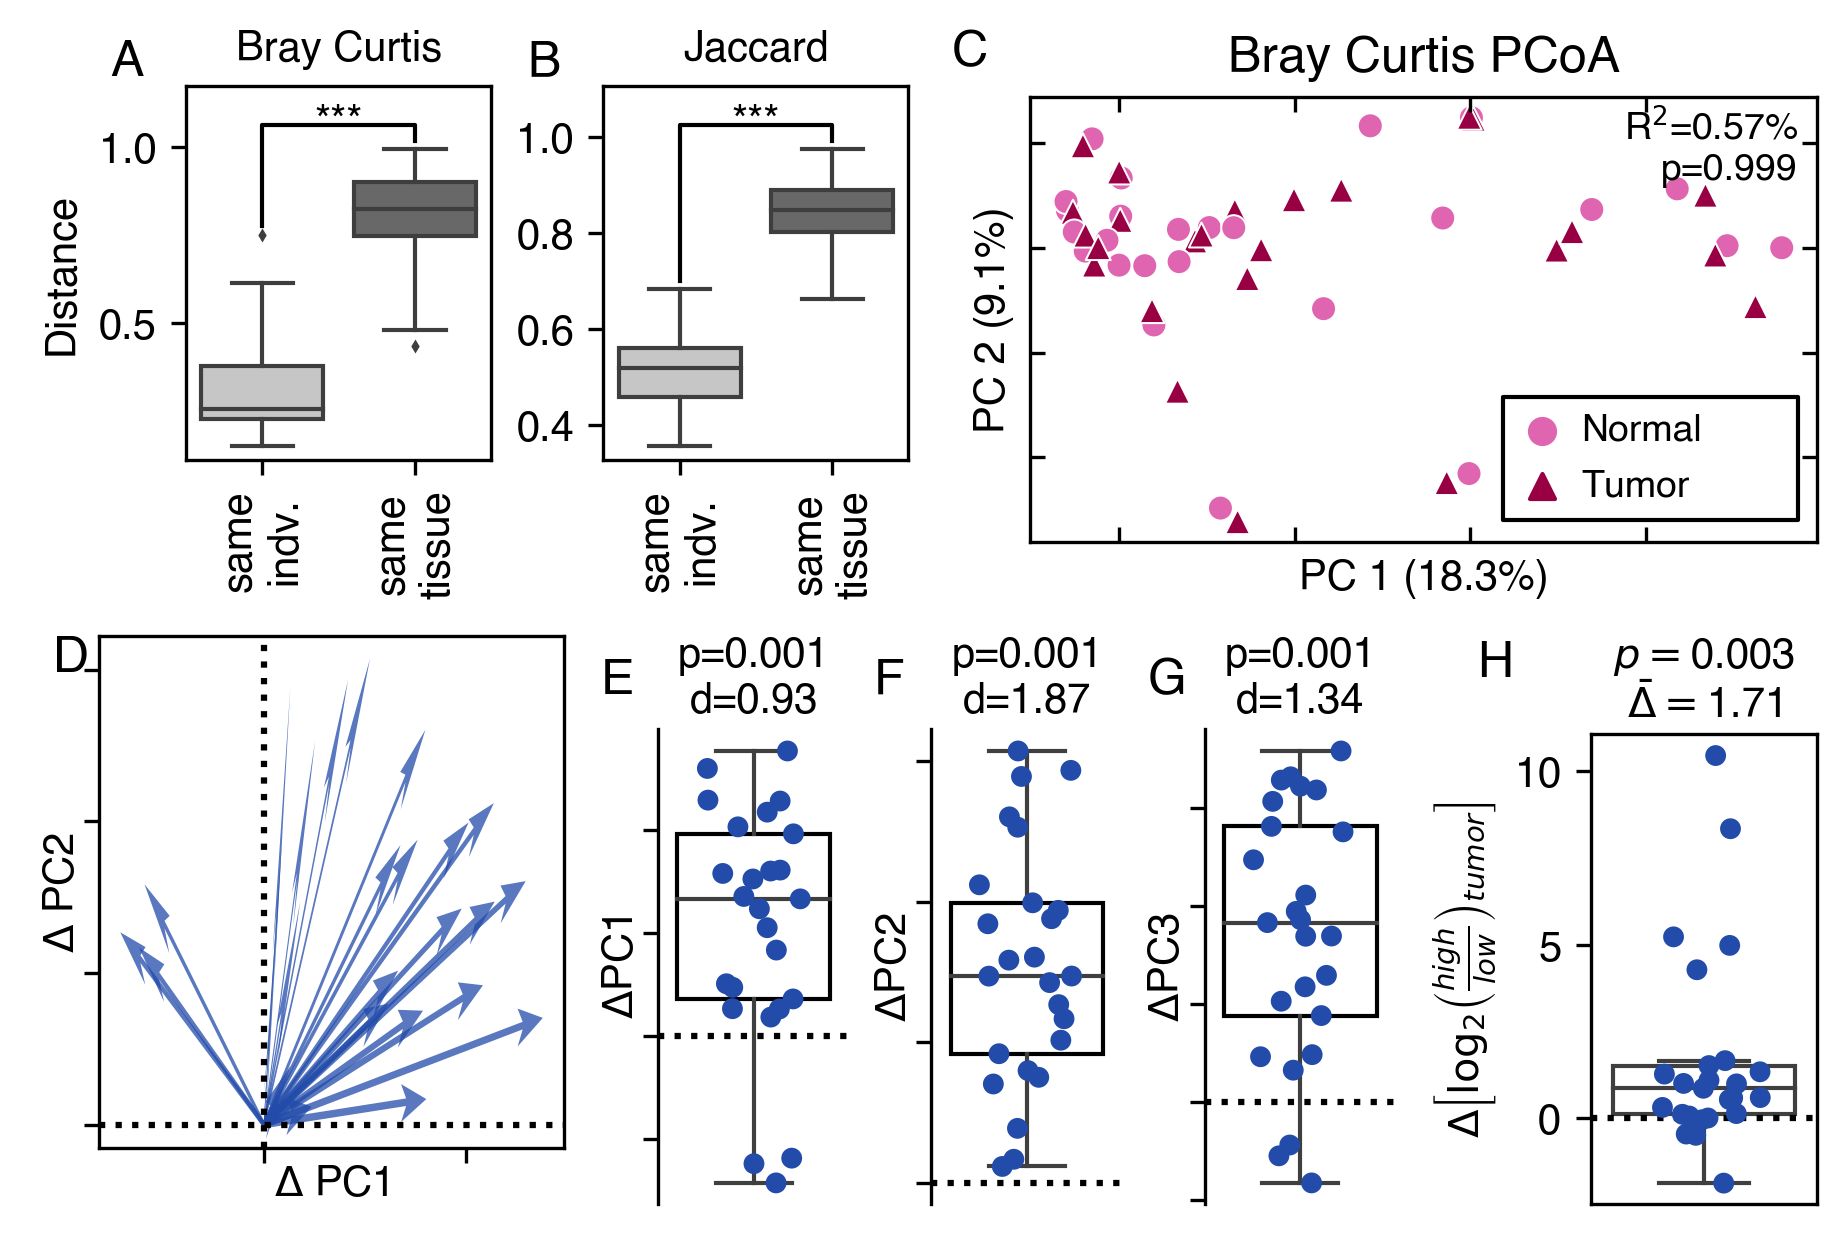

In [87]:
fig_ = plt.figure(dpi=300, constrained_layout=True, figsize=(6, 4), facecolor='None')
fig_0, fig_1 = fig_.subfigures(2, 1, height_ratios=[3, 3])
fig00, fig10 = fig_0.subfigures(1, 2)
fig01, fig11, fig21 = fig_1.subfigures(1, 3, width_ratios=[2, 3, 1.5,])

gs00 = fig00.add_gridspec(1, 2)

# ### Within individual ###
for i, (metric, p) in enumerate(zip(*(['braycurtis', 'jaccard'], [bc_p, jacc_p]))):
    ax = fig00.add_subplot(gs00[:, i])
    
    sn.boxplot(x='group', 
               y=metric, 
               data=dm_long, 
               order=[1, 0],  
               palette='Greys',
               linewidth=1,
               fliersize=1,
               whis=2,
               ax=ax,
              )
    ylim = ax.get_ylim()
    ydiff = np.diff(ylim)
    tops = dm_long.groupby('group')[metric].max()
    upper = np.array([tops[1], tops.max() + ydiff * 0.05, 
                      tops.max() + ydiff * 0.05, tops[0]], dtype=object)
    upper = upper.astype(float)
    ax.plot(np.array([0, 0, 1, 1]), upper + 0.025 * ydiff, 'k-', linewidth=1)
    ax.text(x=0.5, 
            y=tops.max() + ydiff * 0.08, 
            s=''.join(['*'] * int(-np.log10(p))),
            ha='center',
            va='center'
            )
    ax.set_ylim(ylim[0], ylim[1] + 0.15 * ydiff)
    ax.set_xticklabels(['same\nindv.', 'same\ntissue'], rotation=90)
    ax.xaxis.get_label().set_visible(False)
    ax.set_ylabel('Distance')
    ax.yaxis.get_label().set_visible(i == 0)
    ax.set_title(metric.replace('yc', 'y c').title(), size=10)

    ax.text(-1, ax.get_ylim()[1], 'AB'[i], size=12, ha='left', va='bottom') 
    
# ### Bray Curtis PCoA ###
bc_pcoa = skbio.stats.ordination.pcoa(dms['braycurtis'])
bc_coords = pd.concat(axis=1, objs=[bc_pcoa.samples, crc_multi])
bc_coords['PC2'] = bc_coords['PC2'] * -1
bc_pairs = bc_coords.pivot(index='Patient', columns='site_number', values=['PC1', 'PC2'])

ax01 = fig10.add_subplot(1,1,1)

sn.scatterplot(
    x='PC1', y='PC2',
    data=bc_coords,
    ax=ax01,
    hue='site_number',
    style='site_number',
    markers=['o', '^'],
    palette=['#df65b0', '#980043'],
    legend=False,
)
xlim = ax01.get_xlim()
ylim = ax01.get_ylim()
ax01.fill_between(x=xlim[0] + np.array([0.6, 0.975]) * np.diff(xlim),
                  y1=ylim[0] + 0.05 * np.diff(ylim), 
                  y2=ylim[0] + 0.325 * np.diff(ylim), 
                  linewidth=1,
                  facecolor='w',
                  edgecolor='k'
                 )
ax01.set_xlim(xlim)
ax01.set_ylim(ylim)
ax01.scatter(xlim[0] + 0.65 * np.diff(xlim), 
             ylim[0] + 0.25 * np.diff(ylim), 
             marker='o',
             color='#df65b0'
             )
ax01.scatter(xlim[0] + 0.65 * np.diff(xlim), 
             ylim[0] + 0.125 * np.diff(ylim), 
             marker='^',
             color='#980043'
             )
ax01.text(xlim[0] + 0.70 * np.diff(xlim), 
          ylim[0] + 0.25 * np.diff(ylim), 
          'Normal', size=9, ha='left', va='center'
         )
ax01.text(xlim[0] + 0.70 * np.diff(xlim), 
          ylim[0] + 0.125 * np.diff(ylim), 
          'Tumor', size=9, ha='left', va='center'
         )

ax01.xaxis.set_tick_params(left=True, right=True, 
                           labelleft=False, labelright=False,
                           tickdir='in')
ax01.yaxis.set_tick_params(left=True, right=True, 
                           labelleft=False, labelright=False,
                           tickdir='in')
ax01.set_xlabel('PC 1 ({0:1.1%})'.format(*bc_pcoa.proportion_explained), size=10)
ax01.set_ylabel('PC 2 ({1:1.1%})'.format(*bc_pcoa.proportion_explained), size=10)
ax01.text(xlim[0] - 0.1 * np.diff(xlim), ylim[1] + 0.1 * np.diff(ylim), 'C', ha='left', va='center',
          size=12)
ax01.text(xlim[1] - 0.025 * np.diff(xlim), ylim[1] - 0.025 * np.diff(ylim),
          'R$^2$=0.57%\np=0.999',
          size=9,
          ha='right',
          va='top')
ax01.set_title('Bray Curtis PCoA')




# ### CTF axes ###
gs = fig11.add_gridspec(1, 3)
for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    ax = fig11.add_subplot(gs[0, i])
    sn.boxplot(
        y=ctf_coord_d[pc],
        linewidth=1,
        fliersize=0,
        boxprops={'edgecolor': 'k', 'facecolor':'w'},
        # palette=['w'],
        ax=ax,
    )
    sn.stripplot(
        y=ctf_coord_d[pc],
        edgecolor='None',
        palette=['#224baa'],
        jitter=0.25,
        # marker='.',
        s=5,
#         alpha=0.75,
        ax=ax,
    )
    ax.plot(ax.get_xlim(), [0, 0], 'k:')
    ax.set_ylabel(f"$\Delta${pc}")
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    sn.despine(ax=ax, bottom=True, top=True, right=True, trim=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    ax.set_xlabel(
        'p={2:1.3f}\nd={3:1.2f}'.format(
            *permutative_paired_t_test(ctf_coord_wide[pc][1].copy().values,
                                       ctf_coord_wide[pc][0].copy().values))
    )
    ax.xaxis.set_label_position('top')
    
    ax.text((ax.get_xlim()[0] - 0.3 * np.absolute(np.diff(ax.get_xlim()))),
        (ax.get_ylim()[1] + 0.15 * np.absolute(np.diff(ax.get_ylim()))),
        list('EFG')[i], 
         size=12, 
         ha='left', 
         va='top')
    
# ### CTF rotation ###
ax_ = fig01.add_subplot(1,1,1)
ax_.scatter(ctf_coords_diff['PC2'], ctf_coords_diff['PC3'], s=0)
for id_, [pc0, pc1, pc2] in ctf_coords_diff[['PC1', 'PC2', 'PC3']].iterrows():
    ax_.arrow(x=0, dx=pc0, y=0, dy=pc1, 
              length_includes_head=1,
              facecolor='#224baa',
              width=0.005,
              head_width=0.025,
              head_length=0.25,
              overhang=0.2,
              edgecolor='None',
              alpha=0.75,
              )
ax_.set_xlim(fig11.axes[0].get_ylim())
ax_.set_ylim(fig11.axes[1].get_ylim())
ax_.plot([0, 0], ax_.get_ylim(), 'k:')
ax_.plot(ax_.get_xlim(), [0, 0], 'k:')
ax_.xaxis.set_tick_params(labelleft=False, labelright=False)
ax_.yaxis.set_tick_params(labelleft=False, labelright=False)
ax_.set_xlabel('$\Delta$ PC1')
ax_.set_ylabel('$\Delta$ PC2')
ax_.text(ax_.get_xlim()[0] - np.diff(ax_.get_xlim()) * 0.1,
         ax_.get_ylim()[1], 
         'D', 
         size=12,
         ha='left',
         va='top'
        )


# ALR
ax_alr = fig21.add_subplot(1,1,1)
sn.boxplot(
    ax=ax_alr, 
    data=alr_diff.values,
    boxprops={'facecolor': 'w'},
    fliersize=0,
    linewidth=1,
)
sn.stripplot(
    data=alr_diff.values,
    edgecolor='None',
    palette=['#224baa'],
    jitter=0.25,
    s=5,
    ax=ax_alr,
)
xlim = ax_alr.get_xlim()
ax_alr.set_xlim(xlim)
ax_alr.plot(xlim, [0, 0], 'k:')
ax_alr.xaxis.set_tick_params(bottom=False, labelbottom=False)
ax_alr.set_ylabel('$\\Delta \\left [ \\log_{2} \\left ( \\frac{high}{low} \\right )_{tumor} \\right ]$')
ax_alr.set_xlabel(''.join(['$p=$', '{1:1.1g}'.format(*fit_.pvalues),
                           '\n$\\bar{\Delta}=$', '{1:1.2f}'.format(*fit_.params),
                             ]))
ax_alr.xaxis.set_label_position('top')
ax_alr.text(-1, ax_alr.get_ylim()[1] + np.diff(ax_alr.get_ylim()) * 0.2, 
              'H', size=12, ha='left', va='top')

fig_.savefig('figure_s4_replication.png', dpi=300)
fig_.savefig('figure_s4_replication.pdf', dpi=300)
